In [1]:
import sys
sys.path.append("..")

import numpy as np
from numpy import random

from tqdm import tqdm

from pygmo import hypervolume

from utils import utils, plot
import matplotlib.pyplot as plt

# 1. Read metrics data

In [2]:
ref_point = [1.0, 1.0]

lrs_list = [num / 10000 for num in range(5, 105, 5)]
lrs_arr = np.array(lrs_list)

# Read data

## Adam
all_adam_matrics_list = [
    utils.ReadFileGetMetrics("../resnet_metrics_TrainTest/Adam/lr_" + format(lr, "8f").replace(".", "") + "_betas_09_0999_metrics.csv").astype(np.float32)
    for lr in lrs_list
]
all_adam_matrics_arr = np.row_stack(all_adam_matrics_list)

## Adamax
all_adamax_matrics_list = [
    utils.ReadFileGetMetrics("../resnet_metrics_TrainTest/Adamax/lr_" + format(lr, "8f").replace(".", "") + "_betas_09_0999_metrics.csv").astype(np.float32)
    for lr in lrs_list
]
all_adamax_matrics_arr = np.row_stack(all_adamax_matrics_list)

## NAdam
all_nadam_matrics_list = [
    utils.ReadFileGetMetrics("../resnet_metrics_TrainTest/NAdam/lr_" + format(lr, "8f").replace(".", "") + "_betas_09_0999_metrics.csv").astype(np.float32)
    for lr in lrs_list
]
all_nadam_matrics_arr = np.row_stack(all_nadam_matrics_list)

## SGD
all_sgd_matrics_list = [
    utils.ReadFileGetMetrics("../resnet_metrics_TrainTest/SGD/lr_" + format(lr, "8f").replace(".", "") + "_momentum_09_metrics.csv").astype(np.float32)
    for lr in lrs_list
]
all_sgd_matrics_arr = np.row_stack(all_sgd_matrics_list)

## RMSprop
all_rmsprop_matrics_list = [
    utils.ReadFileGetMetrics("../resnet_metrics_TrainTest/RMSprop/lr_" + format(lr, "8f").replace(".", "") + "_metrics.csv").astype(np.float32)
    for lr in lrs_list
]
all_rmsprop_matrics_arr = np.row_stack(all_rmsprop_matrics_list)

In [5]:
# Get true pareto set

true_pareto_set = utils.collect_efficient_solutions(
    all_adam_matrics_list +\
    all_adamax_matrics_list +\
    all_nadam_matrics_list +\
    all_sgd_matrics_list +\
    all_rmsprop_matrics_list
)

true_pareto_matrix = np.row_stack(true_pareto_set)

# 2. Plot scatter

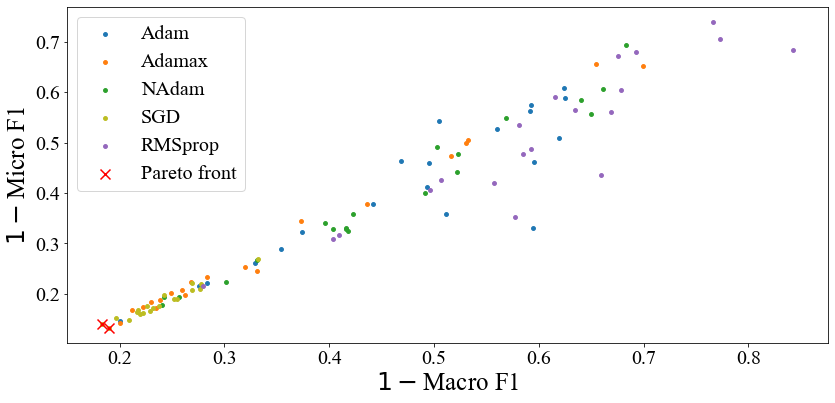

In [6]:
plt.rcParams.update({'font.family':'Times New Roman', 'font.size': 20})

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(*all_adam_matrics_arr.T, label="Adam", s=15, fc='tab:blue')
ax.scatter(*all_adamax_matrics_arr.T, label="Adamax", s=15, fc='tab:orange')
ax.scatter(*all_nadam_matrics_arr.T, label="NAdam", s=15, fc='tab:green')
ax.scatter(*all_sgd_matrics_arr.T, label="SGD", s=15, fc='tab:olive')
ax.scatter(*all_rmsprop_matrics_arr.T, label="RMSprop", s=15, fc='tab:purple')
ax.scatter(*true_pareto_matrix.T, c='red', s=100, marker="x", label="Pareto front")

ax.set_xlabel(r"$1 - $Macro F1", size=25)
ax.set_ylabel(r"$1 - $Micro F1", size=25)
ax.legend()
# ax.legend(prop={'size': 12})
fig.tight_layout()

plt.show()

# 3. Compare to random select

In [7]:
# Factors
all_lr_arr = np.concatenate([lrs_arr.reshape(-1)] * 5)

all_w = np.row_stack([
    np.column_stack([[i+1] * lrs_arr.size, lrs_arr.reshape(-1)])
    for i in range(5)
]).astype(np.float32)

# Responses
all_matrics_arr = np.row_stack([
    all_adam_matrics_arr,
    all_adamax_matrics_arr,
    all_nadam_matrics_arr,
    all_sgd_matrics_arr,
    all_rmsprop_matrics_arr,
]).astype(np.float32)

y1 = all_matrics_arr[:,0]
y2 = all_matrics_arr[:,1]

In [8]:
# Hypervolume: contribution of true pareto front
hv = hypervolume(true_pareto_set)
true_pareto_contribute = hv.compute(ref_point)

In [13]:
seed_idxs = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 17, 22, 23, 25, 27, 35, 37, 46, 53, 54,
    56, 67, 80, 85, 100, 116, 117, 123, 127, 130, 135, 142, 144, 145, 146, 158, 160, 164, 172, 193,
    195, 207, 239, 244, 260, 261, 263, 303, 308, 315, 316, 321, 337, 352, 359, 362, 382, 386, 387, 395,
    408, 410, 417, 421, 422, 433, 435, 460, 466, 473, 475, 481, 486, 490, 491, 493, 496, 497, 499, 517,
    518, 521, 531, 535, 540, 545, 551, 560, 561, 567, 570, 571, 572, 574, 575, 579, 583, 586, 597, 598,
]

In [14]:
random_select_cr_lists = []
for r_seed in tqdm(seed_idxs):
    random.seed(r_seed)
    indices = random.randint(low=0, high=100, size=30)
    train_y1, train_y2 = y1[indices], y2[indices]
    cr_list = []
    for i in range(10,31):
        current_pareto_set = utils.collect_efficient_solutions([arr for arr in np.column_stack([train_y1[:i], train_y2[:i]])])
        hv = hypervolume(current_pareto_set)
        current_pareto_contribute = hv.compute(ref_point)
        cr_list.append(current_pareto_contribute / true_pareto_contribute)
    random_select_cr_lists.append(cr_list)

100%|██████████| 100/100 [00:00<00:00, 163.56it/s]


In [15]:
mt_list = [utils.load_object("../experiment_result/real/c1_mtqqgp_ss2_ns1/"+str(i+1)+".pkl") for i in range(100)]
mtpp_list = [utils.load_object("../experiment_result/real/c1_mtqqgp_ss2_ns1_pp/"+str(i+1)+".pkl") for i in range(100)]

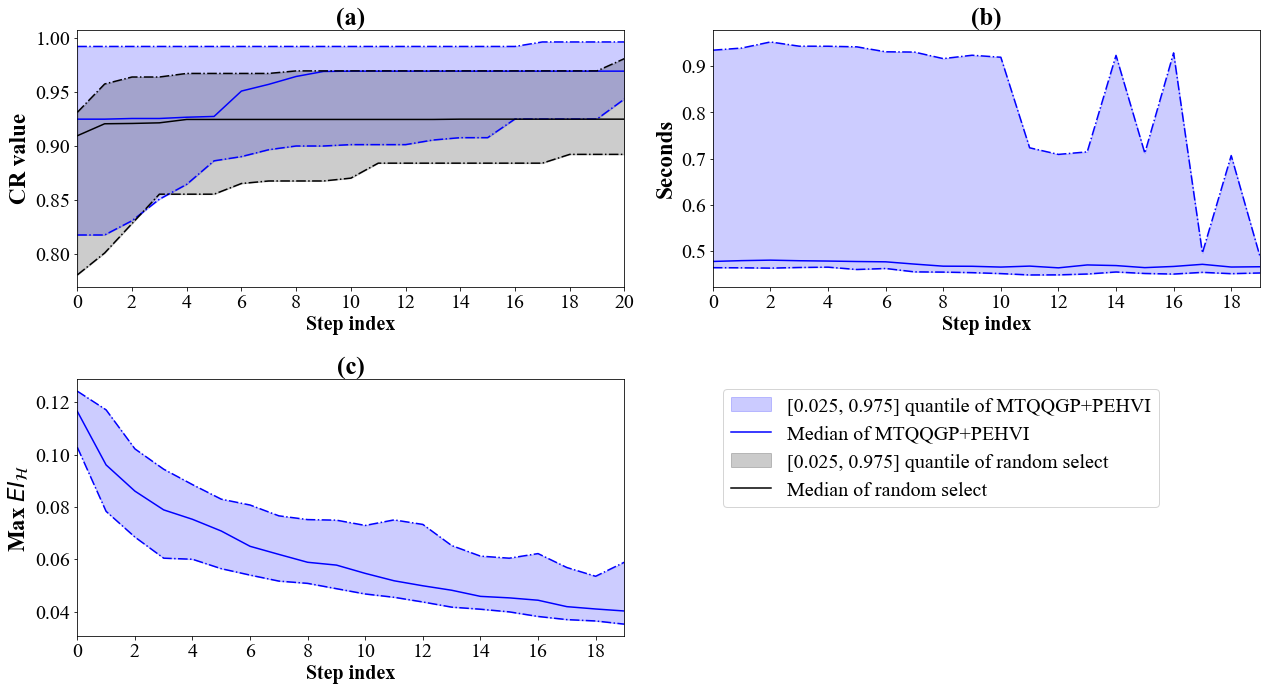

In [16]:
plt.rcParams.update({'font.family':'Times New Roman', 'font.size': 20})
plot.PlotHisQuan(
    cr_lists=[
        [sub_dict["cr"] for sub_dict in mtpp_list],
        random_select_cr_lists,
    ],
    time_lists=[
        [sub_dict["time_cost"] for sub_dict in mtpp_list],
    ],
    eiv_lists=[
        [sub_dict["ei_value"] for sub_dict in mtpp_list],
    ],
    step_num_list=[20,19,19],
    model_name_list=["MTQQGP+PEHVI", "random select"],
    color_list=["blue", "black"],
)